In [1]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
!pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-m

In [2]:
from datasets import load_dataset

# Load the Financial PhraseBank dataset
dataset = load_dataset("financial_phrasebank", "sentences_50agree")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4846
    })
})

In [ ]:
#Split the data into train, validation, and test sets
from datasets import DatasetDict

# Split the original 'train' set into train, validation, and test sets
train_test_split = tokenized_datasets["train"].train_test_split(test_size=0.2)
# Further split the test set into validation and test
validation_test_split = train_test_split["test"].train_test_split(test_size=0.5)

# Combine splits into a new DatasetDict
split_datasets = DatasetDict({
    'train': train_test_split['train'],
    'validation': validation_test_split['train'],
    'test': validation_test_split['test']
})


In [ ]:
# Sample a small part of the datasets for quick experiments
small_train_dataset = split_datasets['train'].shuffle(seed=42).select(range(100))  # 100 samples for training
small_eval_dataset = split_datasets['validation'].shuffle(seed=42).select(range(30))  # 30 samples for validation


In [4]:
import pandas as pd
df = pd.DataFrame(dataset['train'])

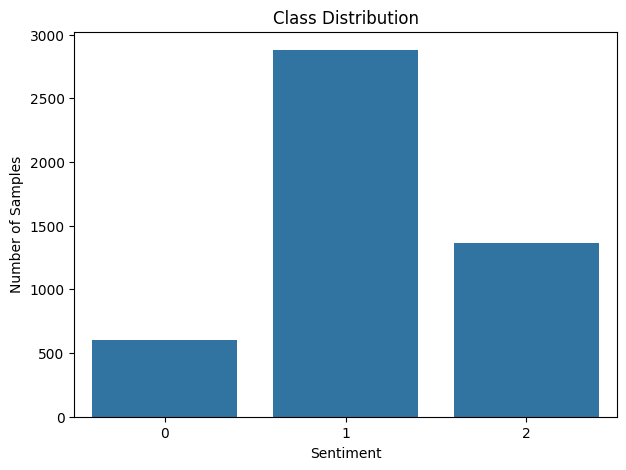

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 'df' is a pandas DataFrame that has already been created and contains the sentiment labels
labels = df['label']
label_counter = Counter(labels)

# Create a bar plot to show the distribution of sentiment labels
plt.figure(figsize=(7, 5))
sns.barplot(x=list(label_counter.keys()), y=list(label_counter.values()))
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Samples')
plt.show()


In [5]:
# Print the dataset structure and a sample
print(dataset)
print(dataset['train'][0:5])


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4846
    })
})
{'sentence': ['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .', 'Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .', 'The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .', 'With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .', "According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales 

In [6]:
#preprocessing
from transformers import AutoTokenizer

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Function to tokenize the data
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

# Apply tokenization to all splits
tokenized_datasets = dataset.map(tokenize_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/4846 [00:00<?, ? examples/s]

In [7]:
#model setup
from transformers import AutoModelForSequenceClassification

# Load a pre-trained BERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#!pip install transformers[torch] accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 25.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [8]:
# Define Training Arguments
from transformers import Trainer, TrainingArguments

# # Define training parameters and configurations for the model
training_args = TrainingArguments(
    output_dir='./results',          # output directory for model checkpoints
    evaluation_strategy="epoch",     # evaluation is done at the end of each epoch
    learning_rate=2e-5,              # learning rate
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    num_train_epochs=3,              # number of training epochs
    weight_decay=0.01                # strength of weight decay
)


In [ ]:
split_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3876
    })
    validation: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 485
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 485
    })
})

In [ ]:
# Split the data into smaller subsets for training and evaluation to enable quicker experimentation.
# Shuffle the train dataset with a fixed seed to ensure reproducibility.
small_train_dataset = split_datasets['train'].shuffle(seed=42).select(range(2000))
# Similarly, shuffle the test dataset and select a smaller subset for validation.
small_eval_dataset = split_datasets['test'].shuffle(seed=42).select(range(500))

In [ ]:
#train the model
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_datasets['train'],
    eval_dataset=split_datasets['validation'],
    tokenizer=tokenizer
)

# Train the model
trainer.train()


NameError: name 'Trainer' is not defined

In [ ]:
# Evaluate the model on the test set
test_results = trainer.evaluate(split_datasets['test'])

# Print test results
print(test_results)
